When benchmarking you **MUST**

1. close all applications
2. close docker
3. close all but this Web windows
4. all pen editors other than jupyter-lab (this notebook)


In [1]:
import os
from cloudmesh.common.Shell import Shell
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
from tqdm.notebook import tqdm
from cloudmesh.common.util import readfile
from cloudmesh.common.util import writefile
from cloudmesh.common.StopWatch import StopWatch 
from cloudmesh.common.systeminfo import systeminfo
import ipywidgets as widgets

sns.set_theme(style="whitegrid")
info = systeminfo()

/home/green/ENV3/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:

user = info["user"] 
node = info["uname.node"]
processors = 4

In [3]:
# Parameters
user = "gregor"
node = "alienware"
processors = 3


In [4]:
p = widgets.IntSlider(
    value=processors,
    min=1,
    max=64,
    step=1,
    description='Processors:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
u = widgets.Text(value=user, placeholder='The user name', description='User:', disabled=False)
n = widgets.Text(value=node, placeholder='The computer name', description='Computer:', disabled=False)

display(p)
display(u)
display(n)

IntSlider(value=3, continuous_update=False, description='Processors:', max=64, min=1)

Text(value='gregor', description='User:', placeholder='The user name')

Text(value='alienware', description='Computer:', placeholder='The computer name')

In [5]:
processors = p.value
user = u.value
node = n.value
print (processors, user, node)

3 gregor alienware


In [6]:

experiments = 10
maximum = 1024 * 100000
intervals = 10

In [7]:
label = f"{user}-{node}-{processors}"
output = f"benchmark/{user}"

delta = int(maximum / intervals)

totals = [64] + list(range(0,maximum, delta))[1:]
points = [int(t/processors) for t in totals]
print (totals)
print(points)

[64, 10240000, 20480000, 30720000, 40960000, 51200000, 61440000, 71680000, 81920000, 92160000]
[21, 3413333, 6826666, 10240000, 13653333, 17066666, 20480000, 23893333, 27306666, 30720000]


In [8]:
os.makedirs(output, exist_ok=True)

In [9]:
systeminfo = StopWatch.systeminfo({"user": user, "uname.node": node})
writefile(f"{output}/{label}-sysinfo.log", systeminfo)
print (systeminfo)

+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | hirsute                                                          |
| DISTRIB_DESCRIPTION | "Ubuntu 21.04"                                                   |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 21.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           |

In [10]:
df = pd.DataFrame(
{"Size": points}
)
df = df.set_index('Size')

In [11]:


experiment_progress = tqdm(range(0, experiments), desc ="Experiment")

experiment = -1
for experiment in experiment_progress:
    exoeriment = experiment + 1

    log = f"{output}/{label}-{experiment}-log.log"
    os.system(f"rm {log}")


    name = points[experiment]
    progress = tqdm(range(0, len(points)), 
                    desc =f"Benchmark {name}",
                    bar_format="{desc:<30} {total_fmt} {r_bar}")
    
    i = -1
    for state in progress:
        i = i + 1
        n = points[i]
        #if linux, os:
        command = f"mpiexec -n {processors} python count-click.py " + \
                  f"--n {n} --max_number 10 --find 8 --label {label} " + \
                  f"--user {user} --node={node} " + \
                  f"| tee -a {log}"
        #if windows: 
        #command = f"mpiexec -n {processors} python count-click.py " + \
        #          f"--n {n} --max_number 10 --find 8 --label {label} " + \
        #          f"--user {user} --node={node} " + \
        #          f">> {log}"
        
        os.system (command)

    content = readfile(log).splitlines()
    lines = Shell.cm_grep(content, "csv,Result:")
    # print(lines)
    values = []
    times = []

    for line in lines:
        msg = line.split(",")[7]
        t = line.split(",")[4]

        total, overall, trials, find, label = msg.split(" ")
        values.append(int(overall))
        times.append(float(t))
        # print (t, overall)


    #data = pd.DataFrame(values, times, columns=["Values", "Time"])

    #print (data.describe())
    #sns.lineplot(data=data, palette="tab10", linewidth=2.5)
    # df["Size"] = values
    df[f"Time_{experiment}"] = times
    # print(df)


Experiment:   0%|          | 0/10 [00:00<?, ?it/s]

Benchmark 21                   10 | 0/10 [00:00<?, ?it/s]

Benchmark 3413333              10 | 0/10 [00:00<?, ?it/s]

Benchmark 6826666              10 | 0/10 [00:00<?, ?it/s]

Benchmark 10240000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 13653333             10 | 0/10 [00:00<?, ?it/s]

Benchmark 17066666             10 | 0/10 [00:00<?, ?it/s]

Benchmark 20480000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 23893333             10 | 0/10 [00:00<?, ?it/s]

Benchmark 27306666             10 | 0/10 [00:00<?, ?it/s]

Benchmark 30720000             10 | 0/10 [00:00<?, ?it/s]

In [12]:

df = df.rename_axis(columns="Time")
df
    

Time,Time_0,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9
Size,,,,,,,,,,
21,0.017,0.000,0.000,0.005,0.005,0.000,0.000,0.004,0.002,0.005
3413333,2.673,2.841,2.761,2.726,2.741,2.757,2.800,2.835,2.734,2.784
6826666,5.458,5.659,5.602,5.299,5.495,5.517,5.464,5.395,5.450,5.521
10240000,8.324,8.398,8.191,8.416,8.186,8.293,8.262,8.196,8.148,8.358
13653333,10.907,10.818,11.068,11.021,11.062,10.697,11.083,10.710,11.054,11.152
17066666,13.600,14.078,13.974,13.401,13.568,13.716,13.667,14.034,13.746,13.872
20480000,16.199,16.749,16.842,16.785,16.341,16.196,16.512,16.075,16.112,16.286
23893333,18.586,19.116,18.946,19.130,18.912,18.990,19.167,19.160,18.767,19.552
27306666,21.490,21.705,21.944,21.547,21.674,21.586,22.569,21.699,22.099,22.219


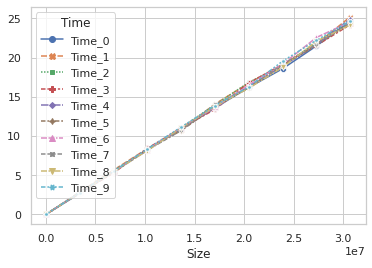

In [13]:
sns.lineplot(data=df, markers=True);

In [14]:
plt.savefig(f'{output}/{label}-line.png');
plt.savefig(f'{output}/{label}-line.pdf');

<Figure size 432x288 with 0 Axes>

In [15]:
dfs = df.stack().reset_index()
dfs = dfs.set_index('Size')
dfs = dfs.drop(columns=['Time'])
dfs = dfs.rename(columns={0:'Time'})
dfs

,Time
Size,
21,0.017
21,0.000
21,0.000
21,0.005
21,0.005
...,...
30720000,24.477
30720000,24.574
30720000,24.406


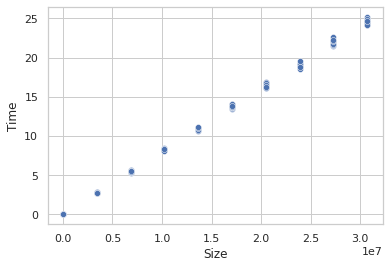

In [16]:
sns.scatterplot(data=dfs, x="Size", y="Time");
plt.savefig(f"{output}/{label}-scatter.pdf")
plt.savefig(f"{output}/{label}-scatter.png")

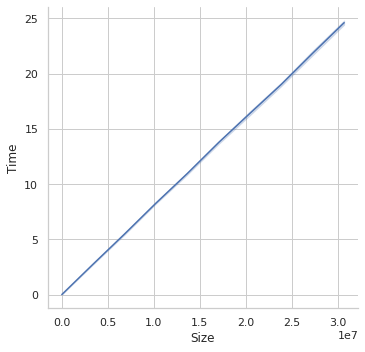

In [17]:
sns.relplot(x="Size", y="Time", kind="line", data=dfs);
plt.savefig(f"{output}/{label}-relplot.pdf")
plt.savefig(f"{output}/{label}-relplot.png")

In [18]:
df.to_pickle(f"{output}/{label}-df.pkl")